# Negative expanded income

The bottom decile from both PUF and CPS have negative aggregate expanded income, as reported in [Tax-Calculator issue 1806](https://github.com/open-source-economics/Tax-Calculator/issues/1806). More information was requested in [taxdata issue 143](https://github.com/open-source-economics/taxdata/issues/143), in which codykallen@ said:

> Based on a quick tabulation for 2017, there are 5066 filing units with negative expanded income, corresponding to 1.53 million tax filers. Of these 5066 units with negative expanded income, 1943 have a capital loss (`c23650` < 0), 1591 have a Schedule C (sole proprietorship) loss (`e00900` < 0), and 3507 have a Schedule E (partnership, S corporation, and passive business) loss (`e02000` < 0).

This notebook reproduces those results to the extent possible using CPS data (which lacks `c23650` and `e02000`), and performs other analysis requested there.

TL;DR: CPS losses are explained by 1.4% of the bottom decile, and Schedule C explains 0.15% of this loss.

## Setup

In [1]:
import taxcalc as tc
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_style('white')
DPI = 300
mpl.rc("savefig", dpi=DPI)
mpl.rcParams['figure.dpi']= DPI

In [3]:
recs = tc.Records.cps_constructor()
calc = tc.Calculator(records=recs, policy=tc.Policy())
calc.calc_all()

You loaded data for 2014.
Tax-Calculator startup automatically extrapolated your data to 2014.


Create `DataFrame` of the items desired.

Which relevant columns are available? Totals, but really just care about != 0.

In [4]:
print 'c23650 (net capital gain): {:,.0f}'.format(
    (calc.records.c23650 * calc.records.s006).sum())
print 'e00900 (Schedule C): {:,.0f}'.format(
    (calc.records.e00900 * calc.records.s006).sum())
print 'e02000 (Schedule E): {:,.0f}'.format(
    (calc.records.e02000 * calc.records.s006).sum())

c23650 (net capital gain): 0
e00900 (Schedule C): 322,367,371,572
e02000 (Schedule E): 0


In [5]:
df = calc.dataframe(['s006',  # Weight. 
                     'expanded_income', 
                     'aftertax_income', 
                     'e00900',  # Schedule C.
                     'c00100'  # AGI.
                    ])
df.head()

,s006,expanded_income,aftertax_income,e00900,c00100
0,230.016667,46925.154857,38271.758799,0.0,43580.855708
1,194.600000,16314.838518,18301.055152,0.0,15155.446835
2,245.276667,11887.694152,11887.694152,0.0,0.000000
3,171.326667,22435.645156,22824.841501,0.0,20840.330752
4,260.123333,18662.496942,18662.496942,0.0,938.970854


## Preprocessing

Add weight normalized to sum to 100, to simplify percentile calculations.

In [6]:
df['weight'] = 100 * df['s006'] / df['s006'].sum()

Add percentiles of expanded income, after-tax income, and e00900 by sorting and summing `cumsum` of normalized weight.

In [7]:
df.sort_values(by=['expanded_income'], inplace=True)
df['expanded_income_percentile'] = df['weight'].cumsum()
df['expanded_income_s006_cumsum'] = df['s006'].cumsum()

In [8]:
df.sort_values(by=['aftertax_income'], inplace=True)
df['aftertax_income_percentile'] = df['weight'].cumsum()

In [9]:
df.sort_values(by=['e00900'], inplace=True)
df['e00900_percentile'] = df['weight'].cumsum()

Add flags for whether expanded income and `e00900` are negative, zero, or positive. 

In [10]:
df['expanded_income_sign'] = np.where(df['expanded_income'] < 0, 'Negative', 
                                      np.where(df['expanded_income'] > 0, 'Positive', 'Zero'))
df['e00900_sign'] = np.where(df['e00900'] < 0, 'Negative', 
                             np.where(df['e00900'] > 0, 'Positive', 'Zero'))
df['aftertax_income_sign'] = np.where(df['aftertax_income'] < 0, 'Negative', 
                                      np.where(df['aftertax_income'] > 0, 'Positive', 'Zero'))

## Analysis

### Examination

In [11]:
df.head()

,s006,expanded_income,aftertax_income,e00900,c00100,weight,expanded_income_percentile,expanded_income_s006_cumsum,aftertax_income_percentile,e00900_percentile,expanded_income_sign,e00900_sign,aftertax_income_sign
74827,5.480889,6.184868e+07,3.551183e+07,-4.375737e+06,6.182728e+07,0.000003,99.999981,1.631957e+08,99.999981,0.000003,Positive,Negative,Positive
37355,58.108222,-3.184715e+06,-3.196435e+06,-3.734775e+06,-3.368172e+06,0.000036,0.000036,5.810822e+01,0.000036,0.000039,Negative,Negative,Negative
394742,479.483333,-8.336610e+05,-8.339394e+05,-8.417563e+05,-8.345421e+05,0.000294,0.000329,5.375916e+02,0.000329,0.000333,Negative,Negative,Negative
306673,383.603333,-7.121966e+05,-7.142727e+05,-7.268042e+05,-7.132347e+05,0.000235,0.001277,2.083228e+03,0.001277,0.000568,Negative,Negative,Negative
29539,1162.033333,-7.204076e+05,-7.204076e+05,-7.204076e+05,-7.204076e+05,0.000712,0.001041,1.699625e+03,0.001041,0.001280,Negative,Negative,Negative


Examine record with most negative expanded income.

In [12]:
df[df['expanded_income'] == df['expanded_income'].min()]

,s006,expanded_income,aftertax_income,e00900,c00100,weight,expanded_income_percentile,expanded_income_s006_cumsum,aftertax_income_percentile,e00900_percentile,expanded_income_sign,e00900_sign,aftertax_income_sign
37355,58.108222,-3.184715e+06,-3.196435e+06,-3.734775e+06,-3.368172e+06,0.000036,0.000036,58.108222,0.000036,0.000039,Negative,Negative,Negative


### Zero expanded income

> What fraction (using sample weights) of the bottom decile has zero expanded income?

Per below pivot table, 3.78%, or 37.8% of the bottom decile.

In [13]:
pd.pivot_table(df, values='weight', index=['expanded_income_sign'],
               aggfunc=np.sum, margins=True).round(2)

,weight
expanded_income_sign,
Negative,0.14
Positive,96.08
Zero,3.78
All,100.00


### Negative expanded income

> What fraction of the bottom decile has negative expanded income?

Per above pivot table, 0.14% of total tax units, or 1.4% of the bottom decile.

In [14]:
neg_ei = df[df['expanded_income'] < 0].sort_values(by=['expanded_income'])

Aggregate expanded income of tax units with negative expanded income.

In [15]:
agg_neg_ei = (neg_ei['expanded_income'] * neg_ei['s006']).sum()
neg_ei_per_unit = agg_neg_ei / neg_ei['s006'].sum()
print 'Tax units with negative expanded income have a total expanded income of -${:.1f}B'.format(
    -agg_neg_ei / 1e9)
print 'This is an average of -${:,.0f} per tax unit.'.format(-neg_ei_per_unit)

Tax units with negative expanded income have a total expanded income of -$23.8B
This is an average of -$105,745 per tax unit.


CDF.

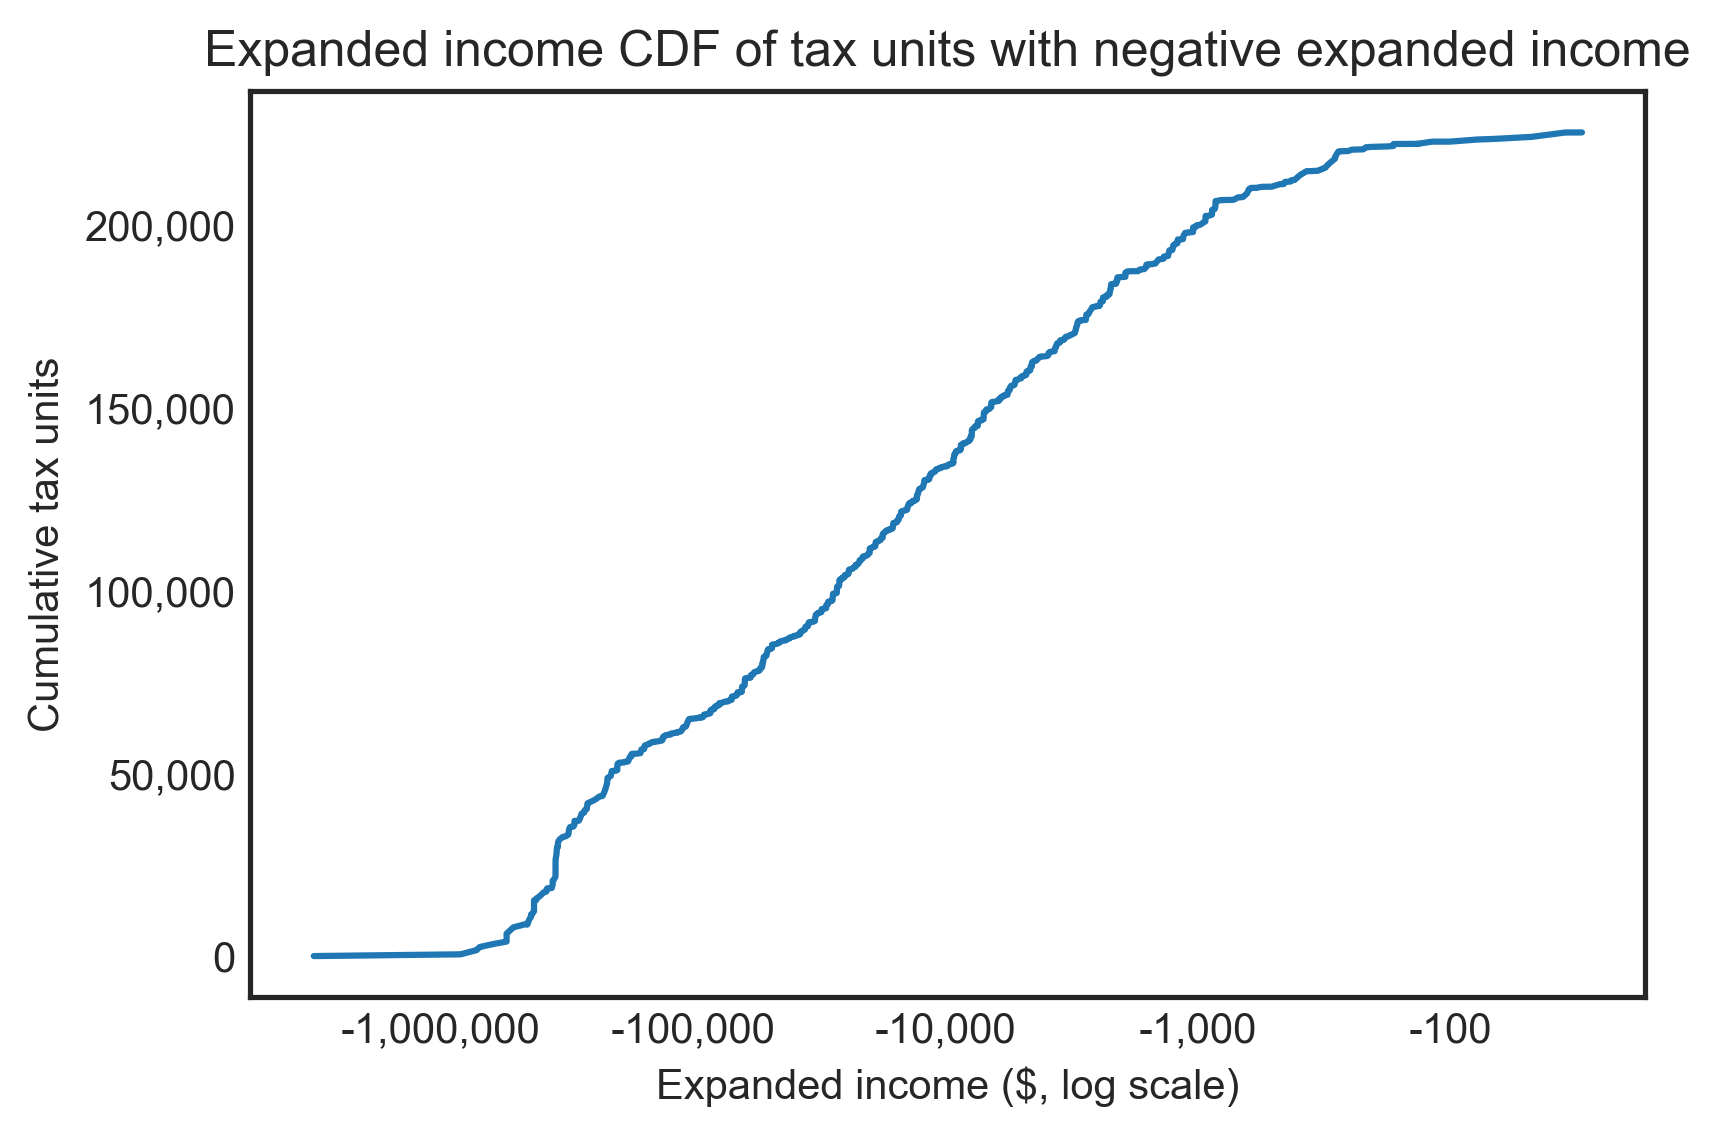

In [16]:
f, ax = plt.subplots()

line, = ax.plot(neg_ei['expanded_income'], neg_ei['expanded_income_s006_cumsum'])

plt.xscale('symlog')

ax.get_yaxis().set_major_formatter(plt.FuncFormatter(
    lambda x, loc: "{:,}".format(int(x))))

ax.get_xaxis().set_major_formatter(plt.FuncFormatter(
    lambda x, loc: "{:,}".format(int(x))))

ax.set(xlabel='Expanded income ($, log scale)', ylabel='Cumulative tax units', 
       title='Expanded income CDF of tax units with negative expanded income')

plt.show()

### Expanded income and `e00900`

> Which input variables cause the negative expanded income for those people?


In [17]:
pd.pivot_table(df, values='weight', index=['expanded_income_sign'],
               columns=['e00900_sign'], aggfunc=np.sum, margins=True,
               fill_value=0).round(2)

e00900_sign,Negative,Positive,Zero,All
expanded_income_sign,,,,
Negative,0.06,0.02,0.06,0.14
Positive,0.23,6.42,89.43,96.08
Zero,0.00,0.00,3.78,3.78
All,0.29,6.44,93.27,100.00


Share of negative expanded income group with negative Schedule C.

In [18]:
print '{:.0f}% of tax units with negative expanded income filed a Schedule C loss.'.format(
    100 * neg_ei[neg_ei['e00900'] < 0]['s006'].sum() / neg_ei['s006'].sum())

41% of tax units with negative expanded income filed a Schedule C loss.


Share of negative expanded income group with positive Schedule C.

In [19]:
print '{:.0f}% of tax units with negative expanded income filed a Schedule C gain.'.format(
    100 * neg_ei[neg_ei['e00900'] > 0]['s006'].sum() / neg_ei['s006'].sum())

18% of tax units with negative expanded income filed a Schedule C gain.


> What would this subgroup's aggregate expanded income be if one or more of the negative income variables were set to zero?

Share of negative expanded income total from Schedule C losses.

In [20]:
print '{:.2f}% of the negative expanded income total is from Schedule C losses.'.format(
    100 * neg_ei[neg_ei['e00900'] < 0]['e00900'].sum() / agg_neg_ei)

0.15% of the negative expanded income total is from Schedule C losses.


Total Schedule C gains from tax units with negative expanded income.

In [21]:
print ('Tax units with negative expanded income and Schedule C gains have an ' +
       'aggregate Schedule C gain of ${:.1f}M.'.format(
           neg_ei[neg_ei['e00900'] > 0]['e00900'].sum() / 1e6))

Tax units with negative expanded income and Schedule C gains have an aggregate Schedule C gain of $7.8M.


### Bottom decile with positive expanded income

> What fraction of the bottom decile has positive expanded income?

Per pivot table above, 63.6% of the bottom decile has positive expanded income.

> What is the aggregate expanded income of this subgroup?

In [22]:
bd_pos_ei = df[(df['expanded_income'] > 0) & (df['expanded_income_percentile'] <= 10)]

In [23]:
agg_bd_pos_ei = (bd_pos_ei['expanded_income'] * bd_pos_ei['s006']).sum()
bd_pos_ei_per_unit = agg_bd_pos_ei / bd_pos_ei['s006'].sum()
print 'Bottom-decile tax units with positive expanded income have a total expanded income of ${:.1f}B'.format(
    agg_bd_pos_ei / 1e9)
print 'This is an average of ${:,.0f} per tax unit.'.format(bd_pos_ei_per_unit)

Bottom-decile tax units with positive expanded income have a total expanded income of $21.0B
This is an average of $2,113 per tax unit.
